In [98]:
import rdkit
from rdkit import Chem
from rdkit.Chem import rdMolEnumerator
from rdkit.Chem import rdTautomerQuery
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [204]:
def plot_peak_boxplots(table_df, parameters, intensitynormmin=0, percentoccurmin=20):
    
    table_df = vx.open("./temp/" + 'table_*.feather') 
    table_df = _construct_df_selections(table_df, parameters)
    table_df = table_df[["spectrum_id"]]

    
    # Merging the spectra
    peak_df = vx.open("./temp/" + 'peak_*.feather')
    peak_df = peak_df.join(table_df, left_on='scan', right_on='spectrum_id', how='inner')
    
    
    # Make vaex dataframe into pandas dataframe
    peak_df = peak_df.to_pandas_df()
    
    
    # Binning MZ values
    peak_df['mz_binned'] = peak_df['mz'].astype('int')
    unique_mz_binned = peak_df['mz_binned'].unique()

    
    # Calculating ratio of scans that DO NOT have a value at mz_binned
    no_peak_ratio = {}
    contains_peak_ratio = {}

    for peak in unique_mz_binned:
        mz_df = peak_df[peak_df["mz_binned"] == peak]
        all_peaks = mz_df['i_norm'].values

        above = sum(i >= intensitynormmin for i in all_peaks)
        below = sum(i < intensitynormmin for i in all_peaks)

        total_scans = len(mz_df)

        no_peak_ratio[peak] = below/total_scans
        
        if above/total_scans >= (percentoccurmin/100):
            contains_peak_ratio[peak] = above/total_scans

        
    # Make dataframe from above calculations
    peak_ratio_df = pd.DataFrame.from_dict(no_peak_ratio, orient='index')
    peak_ratio_df.index.name = 'mz_binned'
    peak_ratio_df = peak_ratio_df.rename(columns={0: "ratio of missing peaks"})
    peak_ratio_df['ratio of present peaks'] = peak_ratio_df.index.map(contains_peak_ratio)
    
    
    # Filter original peak_df
    filtered_peak_df = peak_df[peak_df["i_norm"] > intensitynormmin]

    
    # Plotting: shows how many spectra have a peak at a certain mz_binned and what ratio of spectra with missing peaks
    with open('output_box_peak_df.html', 'w') as f:

        ax = px.box(filtered_peak_df, x='mz_binned',y = 'i_norm')

        # Use hidden line below to graph ratio of MISSING peaks
        #ax.add_bar(x=peak_ratio_df.index, y=-peak_ratio_df["ratio of missing peaks"], name = "ratio of spectra with missing peaks")
        
        ax.add_bar(x=peak_ratio_df.index, y=-peak_ratio_df["ratio of present peaks"], name = "ratio of spectra where at least " + str(percentoccurmin)+"% contain peak")
        
        ax.update_layout(title_text="MS/MS Peak Intensity Distribution")
        
        f.write(ax.to_html(full_html=False, include_plotlyjs='cdn'))
    
    return ax

In [17]:
import numpy as np

In [18]:
import json

In [19]:
#Draw.SetComicMode(IPythonConsole.drawOptions)
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import rdkit
print(rdkit.__version__)
import time
print(time.asctime())

2020.09.1
Mon May  9 07:39:01 2022


In [20]:
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import rdSubstructLibrary

In [21]:
import pandas as pd

In [22]:
url = 'https://gnps-external.ucsd.edu/gnpslibrary/ALL_GNPS.json'

In [23]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [24]:
from urllib.request import urlopen
import json

data = json.loads(urlopen(url).read().decode("utf-8"))

In [25]:
input_library_spec_json = pd.DataFrame.from_dict(data)

In [99]:
input_library = input_library_spec_json

In [198]:
def mol_from_smiles_in_library(library_df):
    
    input_library = library_df
    
    # identifies all SMILES in library dataframe
    smiles_list = input_library[input_library['Smiles'].notnull()]['Smiles'].unique()
    
    # matches SMILES with rdkit molecular object while excluding dataframe rows that do not contain valid SMILES
    smiles_w_rdkit_obj_dict = { AZsmiles : Chem.MolFromSmiles(AZsmiles) for AZsmiles in smiles_list if Chem.MolFromSmiles(AZsmiles) != None }
    
    return smiles_w_rdkit_obj_dict

In [194]:
# returns a subselection of library dataframe for rows containing substructure of interest
def substruct_search_from_smiles(library_spec, smiles_w_rdkit_obj_dict, substruct_search):
    
    input_library = library_spec
    
    smiles_w_rdkit_obj = smiles_w_rdkit_obj_dict
    
    substruct_search = substruct_search
    
    # user input: substructure search as SMILES as string
    substructure_filter = Chem.MolFromSmiles(substruct_search)
    
    # identify rows that contain substructure
    matched_list = [k for k,v in smiles_w_rdkit_obj_dict.items() if v.HasSubstructMatch(substructure_filter)]
    
    library_df_w_substruc_matched = input_library[input_library['Smiles'].isin(matched_list)]
    
    return library_df_w_substruc_matched

In [238]:
smiles_w_rdkit_obj_dict_test = mol_from_smiles_in_library(input_library)

## working code: example w/carnitines

In [244]:
input_library_of_carnitines = input_library[input_library['Compound_Name'].str.contains('carnitine')]

In [246]:
input_library_of_carnitines

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history,Smiles_to_rdkit_obj
4046,CCMSLIB00004684226,f.lfnothias/TEMP/201809_TEMP_REFERENCE_N_ACYL_...,10bf09df91cd4bc49f11f9d042619262,1145,2,GNPS-LIBRARY,1,"[[78.831253,48.000000],[81.134575,89.000000],[...",null-null-null-null,lfnothias,...,2018-09-18 16:17:01.0,fc87812c8b0f4d85811fcb06172d3d60,null,LZOSYCMHQXPBFU-UHFFFAOYSA-N,,C17H33NO4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Decanoyl-L-carnitine', 'Io...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4047,CCMSLIB00004684227,f.lfnothias/TEMP/201809_TEMP_REFERENCE_N_ACYL_...,bf7f0b1faf244732b25797393a0c8bfe,1306,2,GNPS-LIBRARY,1,"[[81.067673,58.000000],[81.868629,39.000000],[...",null-null-null-null,lfnothias,...,2018-09-18 16:16:43.0,84a4551c00454d7dadf16212716efcfa,null,XOMRRQXKHMYMOC-UHFFFAOYSA-O,,C23H46NO4+,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'DL-Lauroylcarnitine', 'Ion...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4048,CCMSLIB00004684228,f.lfnothias/TEMP/201809_TEMP_REFERENCE_N_ACYL_...,a1c8ea94dcb2408aacf28b0a6b499e70,1604,2,GNPS-LIBRARY,1,"[[76.025177,28.000000],[76.907547,37.000000],[...",null-null-null-null,lfnothias,...,2018-09-18 16:16:04.0,348e88fbeac0477dabad132e9bee2e67,null,XOMRRQXKHMYMOC-UHFFFAOYSA-N,,C23H45NO4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'DL-Palmitoylcarnitine', 'I...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4049,CCMSLIB00004684229,f.lfnothias/TEMP/201809_TEMP_REFERENCE_N_ACYL_...,1d3b324f1cf24c119a520d1633e83122,1548,2,GNPS-LIBRARY,1,"[[77.038208,52.000000],[79.039864,68.000000],[...",null-null-null-null,lfnothias,...,2018-09-18 16:15:35.0,0c9c258babc44e4d9354d1ceee93b376,null,SEXHTZQULWPHBX-UHFFFAOYSA-N,,C27H45NO4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'L-Arachidonoylcarnitine', ...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
8203,CCMSLIB00005788025,f.Rommelio_coli/BCAEC_SimT2DM_Metabolomics/BCA...,75c1b7736fdf4037888b23ecf228272c,464,2,GNPS-LIBRARY,1,"[[85.028900,950.000000],[85.030800,180.000000]...",null-null-null-null,Rommelio_coli,...,2021-03-31 22:44:37.0,3aac84de9c164a78ab98267b04e64bf2,null,VVPRQWTYSNDTEA-LLVKDONJSA-N,VVPRQWTYSNDTEA-LLVKDONJSA-N,C13H25NO4,C13H25NO4,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Caproylcarnitine', 'Ion_So...",<rdkit.Chem.rdchem.Mol object at 0x0000015CEEC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574864,CCMSLIB00006121167,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,5049,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[60.080601,62910528.000000],[85.028198,655002...",null-null-null-null,mwang87,...,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,RDHQFKQIGNGIED-MRVPVSSYSA-N,,C9H17NO4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'Acetylcarnitine - 30.0 eV'...,<rdkit.Chem.rdchem.Mol object at 0x0000015CFAB...
574865,CCMSLIB00006121169,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,5050,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[57.792702,2138579.000000],[60.077400,2803314...",null-null-null-null,mwang87,...,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,RDHQFKQIGNGIED-MRVPVSSYSA-N,,C9H17NO4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'Acetylcarnitine - 30.0 eV'...,<rdkit.Chem.rdchem.Mol object at 0x0000015CFAB...
574866,CCMSLIB00006121170,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,5051,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[60.080601,50613920.000000],[73.382797,201758...",null-null-null-null,mwang87,...,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,RDHQFKQIGNGIED-MRVPVSSYSA-N,,C9H17NO4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'Acetylcarnitine - 30.0 eV'...,<rdkit.Chem

In [247]:
input_library_of_carnitines.reset_index().to_csv(
    'C:/Users/Calle/OneDrive - UC San Diego/Dorrestein Lab/Ming_bioinformatics/library_df_carnitine.csv', 
    sep=',', index=False)

In [237]:
carnitine = 'C[N+](C)(C)CC(CC(=O)[O-])O'

In [239]:
library_df_w_carnitine_substruc_matched_test = substruct_search_from_smiles(input_library, smiles_w_rdkit_obj_dict_test, carnitine)

In [241]:
library_df_w_carnitine_substruc_matched_test.head(5)

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history,Smiles_to_rdkit_obj
4046,CCMSLIB00004684226,f.lfnothias/TEMP/201809_TEMP_REFERENCE_N_ACYL_...,10bf09df91cd4bc49f11f9d042619262,1145,2,GNPS-LIBRARY,1,"[[78.831253,48.000000],[81.134575,89.000000],[...",null-null-null-null,lfnothias,...,2018-09-18 16:17:01.0,fc87812c8b0f4d85811fcb06172d3d60,null,LZOSYCMHQXPBFU-UHFFFAOYSA-N,,C17H33NO4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Decanoyl-L-carnitine', 'Io...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4048,CCMSLIB00004684228,f.lfnothias/TEMP/201809_TEMP_REFERENCE_N_ACYL_...,a1c8ea94dcb2408aacf28b0a6b499e70,1604,2,GNPS-LIBRARY,1,"[[76.025177,28.000000],[76.907547,37.000000],[...",null-null-null-null,lfnothias,...,2018-09-18 16:16:04.0,348e88fbeac0477dabad132e9bee2e67,null,XOMRRQXKHMYMOC-UHFFFAOYSA-N,,C23H45NO4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'DL-Palmitoylcarnitine', 'I...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4049,CCMSLIB00004684229,f.lfnothias/TEMP/201809_TEMP_REFERENCE_N_ACYL_...,1d3b324f1cf24c119a520d1633e83122,1548,2,GNPS-LIBRARY,1,"[[77.038208,52.000000],[79.039864,68.000000],[...",null-null-null-null,lfnothias,...,2018-09-18 16:15:35.0,0c9c258babc44e4d9354d1ceee93b376,null,SEXHTZQULWPHBX-UHFFFAOYSA-N,,C27H45NO4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'L-Arachidonoylcarnitine', ...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4050,CCMSLIB00004684230,f.lfnothias/TEMP/201809_TEMP_REFERENCE_N_ACYL_...,d83a0ab3796a47db81fa17fcccb28f64,1538,2,GNPS-LIBRARY,1,"[[82.021034,18.000000],[82.307793,40.000000],[...",null-null-null-null,lfnothias,...,2018-09-18 16:36:46.0,778bf693a1024b7e9d249443e967aeb5,null,MJLXQSQYKZWZCB-UHFFFAOYSA-N,,C25H45NO4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Linoleyl Carnitine', 'Ion_...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
8203,CCMSLIB00005788025,f.Rommelio_coli/BCAEC_SimT2DM_Metabolomics/BCA...,75c1b7736fdf4037888b23ecf228272c,464,2,GNPS-LIBRARY,1,"[[85.028900,950.000000],[85.030800,180.000000]...",null-null-null-null,Rommelio_coli,...,2021-03-31 22:44:37.0,3aac84de9c164a78ab98267b04e64bf2,null,VVPRQWTYSNDTEA-LLVKDONJSA-N,VVPRQWTYSNDTEA-LLVKDONJSA-N,C13H25NO4,C13H25NO4,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Caproylcarnitine', 'Ion_So...",<rdkit.Chem.rdchem.Mol object at 0x0000015CEEC...


In [242]:
library_df_w_carnitine_substruc_matched_test.reset_index().to_csv(
    'C:/Users/Calle/OneDrive - UC San Diego/Dorrestein Lab/Ming_bioinformatics/library_df_carnitine_matches.csv', 
    sep=',', index=False)

## working code: example w/dihydroxy_only

In [ ]:
dihydroxy_only = 'O=CCC[C@@H](C)C1CC[C@@]2([H])C3C(O)C([H])([H])[C@]4([H])CC(O)CC[C@]4(C)[C@@]3([H])CC([H])([H])[C@@]21C'

In [190]:
smiles_w_rdkit_obj_dict_test = mol_from_smiles_in_library(input_library)

In [207]:
library_df_w_substruc_matched_test = substruct_search_from_smiles(input_library, smiles_w_rdkit_obj_dict_test, dihydroxy_only)

In [235]:
library_df_w_substruc_matched_test

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history,Smiles_to_rdkit_obj
4181,CCMSLIB00004722199,f.MSV000083094/peak/mzXML_files/samples/Cholic...,97f5931743d845639f2083a756d8c0cc,1606,2,GNPS-LIBRARY,1,"[[49.502087,0.000000],[49.502419,0.000000],[49...",null-null-null-null,fevargas,...,2019-01-04 13:59:24.0,50bac30f8f0c4c33a66d85013f9f538c,null,LLEBFOGPKXFKIL-UHFFFAOYSA-N,LLEBFOGPKXFKIL-UHFFFAOYSA-N,C27H45NO7,C27H45NO7,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Serine-Cholic Acid', 'Ion_...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4182,CCMSLIB00004722200,f.MSV000083094/peak/mzXML_files/samples/Cholic...,67929c766bb44353ad8fcc1204098e3e,1660,2,GNPS-LIBRARY,1,"[[49.502045,0.000000],[49.502377,0.000000],[49...",null-null-null-null,fevargas,...,2019-01-04 14:28:15.0,67929c766bb44353ad8fcc1204098e3e,null,LLEBFOGPKXFKIL-UHFFFAOYSA-N,LLEBFOGPKXFKIL-UHFFFAOYSA-N,C27H45NO7,C27H45NO7,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Serine-Cholic Acid', 'Ion_...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4183,CCMSLIB00004722201,f.MSV000083094/peak/mzXML_files/samples/Cholic...,17bfad3f154543d69a71f52a2f3fbac6,1658,2,GNPS-LIBRARY,1,"[[49.502041,0.000000],[49.502369,0.000000],[49...",null-null-null-null,fevargas,...,2019-01-04 14:29:17.0,17bfad3f154543d69a71f52a2f3fbac6,null,LLEBFOGPKXFKIL-UHFFFAOYSA-N,LLEBFOGPKXFKIL-UHFFFAOYSA-N,C27H45NO7,C27H45NO7,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Serine-Cholic Acid', 'Ion_...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4186,CCMSLIB00004722204,f.aaksenov/Nobel_study/Twins/Samples/TWDP_001_...,902c7059ff92477498fa4190e1e8c628,1714,2,GNPS-LIBRARY,1,"[[79.052254,35.000000],[80.061600,30.000000],[...",null-null-null-null,aaksenov,...,2019-01-11 14:53:10.0,902c7059ff92477498fa4190e1e8c628,null,CEMZGPKUKMFNNF-UHFFFAOYSA-N,CEMZGPKUKMFNNF-UHFFFAOYSA-N,C33H49NO5,C33H49NO5,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'Putative Chenodeoxycholic ...,<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4613,CCMSLIB00005435972,f.robinschmid/reference_spectra/reference_spec...,ff3fd0225fb442778a31d023e13ea077,1,2,GNPS-LIBRARY,1,"[[337.248718,237.000000],[355.261658,7147.0000...",null-null-null-null,robinschmid,...,2019-06-04 02:57:13.0,ff3fd0225fb442778a31d023e13ea077,null,BHQCQFFYRZLCQQ-OELDTZBJSA-N,BHQCQFFYRZLCQQ-OELDTZBJSA-N,C24H40O5,C24H40O5,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Cholic acid', 'Ion_Source'...",<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584022,CCMSLIB00006126760,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,7149,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[57.975498,15246.870117],[59.013699,652848.37...",null-null-null-null,mwang87,...,2021-04-15 16:27:10.0,ac575833873943cdb89946fc9dec1851,null,RUDATBOHQWOJDD-UZVSRGJWSA-N,,C24H40O4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'Ursodeoxycholic acid - 40....,<rdkit.Chem.rdchem.Mol object at 0x0000015CEEC...
584023,CCMSLIB00006126761,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,7150,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[52.468300,9043.679688],[57.975601,21483.5195...",null-null-null-null,mwang87,...,2021-04-15 16:27:10.0,ac575833873943cdb89946fc9dec1851,null,RUDATBOHQWOJDD-UZVSRGJWSA-N,,C24H40O4,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'Ursodeoxycholic acid - 40....,<rdkit.Chem.rdchem.Mol object at 0x0000015CEEC...
584024,CCMSLIB00006126762,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,7151,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[57.975498,24775.300781],[58.809299,8468.9404...",null-null-null-null,mwang87,...,2021-04-15 16:27:10.0,ac575833873943cdb89946fc9dec1851,null,RUDATBOHQWOJDD-UZVS

In [234]:
library_df_w_substruc_matched_test.reset_index().to_csv(
    'C:/Users/Calle/OneDrive - UC San Diego/Dorrestein Lab/Ming_bioinformatics/library_df_dihydroxy_only_matches.csv', 
    sep=',', index=False)

In [231]:
dihydroxy_only_matches = library_df_w_substruc_matched_test[['Compound_Name','Smiles']]

In [232]:
dihydroxy_only_matches.reset_index().to_csv(
    'C:/Users/Calle/OneDrive - UC San Diego/Dorrestein Lab/Ming_bioinformatics/dihydroxy_only_matches.csv', 
    sep=',', index=False)

In [224]:
library_df_w_substruc_matched_test.Compound_Name.unique()

array(['Serine-Cholic Acid',
       'Putative Chenodeoxycholic acid Phenylalanine conjugate',
       'Cholic acid',
       'putative tryptophane conjugated chenodeoxycholic acid',
       'Putative Phenylalanine conjugated chenodeoxycholic acid',
       'putative tryptophane conjugated chenodeoxycholic acid (clustered spectrum)',
       'Lysine conjugated cholic acid',
       'Histidine conjugated cholic acid ', 'Tyrosocholic acid',
       'Lysine conjugated deoxycholic acid putative',
       'Tyrosine conjugated deoxycholic acid putative',
       'Glutamine conjugated cholic acid',
       'Leucine conjugated chenodeoxycholic acid',
       'Leucine conjugated chenodeoxycholic acid putative',
       'Phenylalanine conjugated chenodeoxycholic acid',
       'Tryptophane chenodeoxycholic acid', 'Methiocholic acid putative',
       'Tauroursocholic acid', 'Tauroallocholic acid',
       'SUDCA - Sulfoursodeoxycholic acid',
       'SCDCA - Sulfochenodeoxycholic acid', 'SCA - Sulfocholic acid',

In [225]:
library_df_w_substruc_matched_test.Smiles.unique()

array(['CC(C1CCC2C1(C)C(O)CC3C2C(O)CC4C3(C)CCC(O)C4)CCC(NC(CO)C(O)=O)=O',
       'CC(C1CCC2C1(C)CCC3C2C(O)CC4C3(C)CCC(O)C4)CCC(NC(CC5=CC=CC=C5)C(O)=O)=O',
       '[H][C@@]12C[C@H](O)CC[C@]1(C)[C@@]1([H])C[C@H](O)[C@]3(C)[C@]([H])(CC[C@@]3([H])[C@]1([H])[C@H](O)C2)[C@H](C)CCC(O)=O',
       'CC(C1CCC2C1(C)CCC3C2C(O)CC4C3(C)CCC(O)C4)CCC(NC(C(O)=O)CC5=CNC6=CC=CC=C65)=O',
       'CC(C1CCC2C1(C)CCC3C2C(O)CC4C3(C)CCC(O)C4)CCC(NC(C(O)=O)CC5=CC=CC=C5)=O',
       'C[CH](CCC(NC(CCCCN)C(O)=O)=O)[CH]1CC[CH]2[C]3([H])[CH](O)C[C]4([H])C[CH](O)CC[C]4(C)[CH]3C[CH](O)[C]21C',
       'C[CH](CCC(N[CH](CC1=CNC=N1)C(O)=O)=O)[CH]2CC[C]3([H])[C]4([H])[CH](O)C[C]5([H])C[CH](O)CC[C]5(C)[CH]4C[CH](O)[C]32C',
       '[H][C]12[CH](O)C[CH]3C[CH](O)CC[C]3(C)[CH]1C[CH](O)[C]4(C)[CH]2CC[CH]4[CH](CCC(NC(CC5=CC=C(O)C=C5)C(O)=O)=O)C',
       'CC(C1CCC2C3(C(CC4(CC(CCC4(C3CCC21C)C)O)[H])O)[H])CCC(NC(C(O)=O)CCCCN)=O',
       '[H]C12C(O)CC3CC(CCC3(C1CCC4(C2CCC4C(C)CCC(NC(C(O)=O)CC5=CC=C(C=C5)O)=O)C)C)O',
       'C[CH](CCC(N[

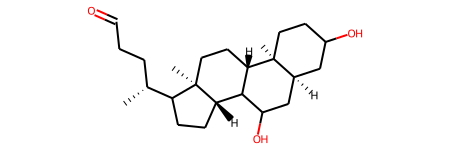

In [214]:
Chem.MolFromSmiles(dihydroxy_only)

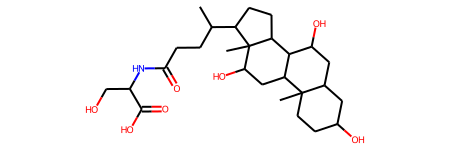

In [213]:
Chem.MolFromSmiles(library_df_w_substruc_matched_test['Smiles'].to_list()[1])

In [ ]:
plot_peak_boxplots(parameters, intensitynormmin=0, percentoccurmin=20)

In [177]:
matched_list = [k for k,v in smiles_w_rdkit_obj_dict.items() if v.HasSubstructMatch(substructure_filter)]

In [186]:
matched_list

['[H][C@@]12C[C@H](O)CC[C@]1(C)[C@@]1([H])C[C@H](O)[C@]3(C)[C@]([H])(CC[C@@]3([H])[C@]1([H])[C@H](O)C2)[C@H](C)CCC(O)=O',
 'CC(CCC(=O)O)C1CCC2C1(CCC3C2C(CC4C3(CCC(C4)OS(=O)(=O)O)C)O)C',
 'CC(CCC(=O)O)C1CCC2C1(C(CC3C2C(CC4C3(CCC(C4)O)C)OS(=O)(=O)O)O)C',
 'C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2[C@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)C',
 'C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)C[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3CC[C@]12C',
 'C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)C',
 'C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)O)C',
 'CC(CCC(=O)O)C1CCC2C1(CCC3C2C(CC4C3(CCC(C4)O)C)O)C',
 '[H][C@@]1(CC[C@@]2([H])[C@]3([H])[C@H](O)C[C@]4([H])C[C@H](O)CC[C@]4(C)[C@@]3([H])C[C@H](O)[C@]12C)[C@H](C)CCC(O)=O',
 'C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2[C@@H]([C@@H]([C@H]4[C@@]3(CC[C@H](C4)O)C)O)O)C',
 '[H][C@@]1([C@H](O)C[C@H]2[C@]3(C)[C@H](O)C[C@@H](O)C2)[C@@H]3CC[C@@]4(C)[C@H]1CC

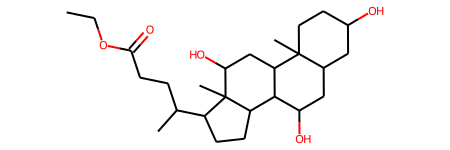

In [201]:
Chem.MolFromSmiles(matched_list[100])

In [178]:
library_df_w_substruc_matched = input_library[input_library['Smiles'].isin(matched_list)]

In [187]:
dh

'C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)C'

In [183]:
library_df_w_substruc_matched_test = new_substruct_match(input_library, smiles_w_rdkit_obj_dict, dh)

In [135]:
input_library['Smiles_to_rdkit_obj'] = input_library['Smiles'].map(smiles_w_rdkit_obj_dict)

In [136]:
input_library[['Smiles','Smiles_to_rdkit_obj']]

,Smiles,Smiles_to_rdkit_obj
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,<rdkit.Chem.rdchem.Mol object at 0x0000015C58A...
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
2,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
3,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,<rdkit.Chem.rdchem.Mol object at 0x0000015CE9D...
4,N/A,NaN
...,...,...
584101,CCCCCC(=O)NCC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x0000015D168...
584102,CCCCCC(=O)NCC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x0000015D168...
584103,CCCCCC(=O)NCC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x0000015D168...
584104,CCCCCC(=O)NCC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x0000015D168...


In [154]:
library_df_w_substruc = [smiles for smiles, rdkit_obj in zip(input_library['Smiles'][~input_library['Smiles'].str.contains('N/A')], input_library['Smiles_to_rdkit_obj'].dropna()) if rdkit_obj.HasSubstructMatch(substructure_filter)]

In [155]:
library_df_w_substruc

['CNCCC1=CNC2=C1C=CC=C2',
 ' Br[C@@H](CC1)[C@](CC[C@H]([C@@](CC[C@H](C(C)(C)OC2=O)Br)(C)O)Br)(C)[C@@](CC(C=C2C=C3)=C3O)([H])C1=C',
 'COC1=C2C3=C(C(=O)CC3)C(=O)OC2=C4C5C=COC5OC4=C1',
 'C1[C@H]([C@H](OC2=CC(=CC(=C21)O)O)C3=CC(=O)C(=C4C(=C3)C(=CC(=C4O)O)[C@@H]5[C@@H](CC6=C(C=C(C=C6O5)O)O)O)O)O',
 'C([C@@H]([C@@H]1C(=C(C(=O)O1)O)O)O)O',
 'C([C@@]1([C@H]2[C@@H]3[C@H](NC(=N)N[C@@]34[C@@H]([C@@H]1O[C@]([C@H]4O)(O2)O)O)O)O)O',
 'C([C@@]1([C@H]2[C@@H]3[C@H](NC(=N)N[C@@]34[C@@H]([C@@H]1O[C@]([C@H]4O)(O2)O)O)O)O)O',
 'C([C@@]1([C@H]2[C@@H]3[C@H](NC(=N)N[C@@]34[C@@H]([C@@H]1O[C@]([C@H]4O)(O2)O)O)O)O)O',
 'COC1=C2C3=C(C(=O)CC3)C(=O)OC2=C4C5CCOC5OC4=C1',
 ' ',
 ' ',
 ' ',
 'O=C(NC1=C(C=CC=C2)C2=CC=C1)C3=CN(CCCCC)C4=C3C=CC=C4',
 'CC(CC(/C=C(C(N(CC1=NC=CS1)C)=O)/C)C)CC/C(CCCN(C(CC(O)C)=O)C)=C\\Cl',
 '[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCCCCCCCCCCCCCC)OC(=O)CCCCCCCCCCCCCCCCC)C(O)=O',
 '[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCCCCCCCCCC)OC(=O)CCCCCCCCCCCCC)C(O)=O',
 '[H][C@@](COC(=O)CCCCCCCC

In [ ]:
library_df_w_substruc = input_library[input_library['Smiles'].isin(matches)]

## OLD CODE: DOESN'T WORK

In [102]:
mol_from_smiles = [Chem.MolFromSmiles(AZsmiles) for AZsmiles in smiles_list]
mol_from_smiles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 ...]

In [104]:
# matches SMILES with rdkit molecular object
smiles_w_rdkit_obj_all = dict(zip(np.unique(smiles_list),mol_from_smiles))
smiles_w_rdkit_obj_all

{'': <rdkit.Chem.rdchem.Mol at 0x15c58992cb0>,
 ' ': <rdkit.Chem.rdchem.Mol at 0x15c589921c0>,
 '    [H][C@@](O)(CC1=CC=C(O)C=C1)C(O)=N[C@@]([H])(C(=O)N1[C@@]([H])(C[C@]2([H])CC[C@]([H])(C[C@]12[H])OS(O)(=O)=O)C(O)=NCCCCNC(N)=N)[C@]([H])(C)CC': <rdkit.Chem.rdchem.Mol at 0x15c58992940>,
 ' Br[C@@H](CC1)[C@](CC[C@H]([C@@](CC[C@H](C(C)(C)OC2=O)Br)(C)O)Br)(C)[C@@](CC(C=C2C=C3)=C3O)([H])C1=C': <rdkit.Chem.rdchem.Mol at 0x15c58992260>,
 ' C(C(C(=O)O)N)C(=O)O': None,
 ' C(C(C(=O)O)N)O': <rdkit.Chem.rdchem.Mol at 0x15c589928f0>,
 ' C(CS(=O)(=O)O)N': <rdkit.Chem.rdchem.Mol at 0x15c589927b0>,
 ' C/C(=C\\CCC(=C)C(CN=C(Cl)Cl)Cl)/CCC1C(O1)(C)C': <rdkit.Chem.rdchem.Mol at 0x15c589923a0>,
 ' C/C(C)=C\\C/C=C(C)/C1C(C(N([H])C1)C(O)=O)CC(O)=O': <rdkit.Chem.rdchem.Mol at 0x15c589924e0>,
 ' C12=C(NC(=O)N1)NC(=O)NC2=O': <rdkit.Chem.rdchem.Mol at 0x15c589920d0>,
 ' C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O': <rdkit.Chem.rdchem.Mol at 0x15c58992490>,
 ' C1=CC(=CC=C1C2=CC(=O)C3=C(C(=C(C=C3O2)O)O)O)O': 

In [128]:
len(smiles_w_rdkit_obj_all)

35971

In [105]:
# exclude dataframe rows that do not contain valid SMILES
rem_list = [k for k,v in smiles_w_rdkit_obj_all.items() if v == None]
rem_list

[' C(C(C(=O)O)N)C(=O)O',
 'C(=CC(C)=CC=CC=C(C)C=CC=C(C)C(C=4)OC(C43)(CCCC(C)(C)3)C)C=C(C=CC(C21C)(C(CCC2)(C)C)O1)C',
 'C(C(=O)O)(Cl)Cl',
 'C(C)(=O)NC(C(=O)OCC\\C(=C\\C(=O)N(O)CCCC1NC(C(NC1=O)CCCN(C(\\C=C(\\CCO)/C)=O)O)=O)\\C)CCCN(C(\\C=C(\\CCO)/C)=O)O',
 'C(C)(=O)Nc1ccc(cc1)S(=O)(=O)Nc1nc(cc(n1)OC)OC',
 'C(CC(=O)NC(CS)C(=O)O)C(C(=O)O)N',
 'C(CC)=CCC=CCC=CCC=CCC=CCC=CCCC(OC(COC(CCC=CCCCCCCCCCCCC)=O)COP(O)(=O)OCCN)=O',
 'C(CC)=CCC=CCC=CCC=CCC=CCC=CCCC(OC(COC(CCCCCCCCCCCCCCC)=O)COP(OCC(C(O)=O)N)(O)=O)=O',
 'C(CC=CCCC(=O)OC(COC(CCC=CCCCCCCCCCCCCC)=O)COP(O)(=O)OCCN)CCCCCCCCCCCCC',
 'C(CC=CCCCCCCCCCCCCCCCCC)C(=O)OC(COC(CCCCCCCCCCCCCCCCC)=O)COP(OCCN)(O)=O',
 'C(CCC(=O)O)CCN',
 'C(CCC(=O)OC(COP(OC(C(O)1)C(O)C(O)C(O)C1O)(O)=O)COC(CCC=CCCCCCCCCCCCCC)=O)=CCC=CCC=CCC=CCCCCCC',
 'C(OC1=C(C(=C2C(=C1[H])OC(=C(C2=O)[H])C3=C(C(=C(C(=C3[H])OC([H])([H])[H])OC([H])([H])[H])OC([H])([H])[H])[H])O[H])[H])([H])([H])[H]',
 'C(OC1=C(C2=C(C(=C1O[H])[H])OC(=C(C2=O)[H])C3=C(C(=C(C(=C3[H])[H])O[H])O[H])[H])O[H])([H

In [106]:
smiles_w_rdkit_obj = {key:val for key, val in smiles_w_rdkit_obj_all.items() if key not in rem_list}
smiles_w_rdkit_obj

{'': <rdkit.Chem.rdchem.Mol at 0x15c58992cb0>,
 ' ': <rdkit.Chem.rdchem.Mol at 0x15c589921c0>,
 '    [H][C@@](O)(CC1=CC=C(O)C=C1)C(O)=N[C@@]([H])(C(=O)N1[C@@]([H])(C[C@]2([H])CC[C@]([H])(C[C@]12[H])OS(O)(=O)=O)C(O)=NCCCCNC(N)=N)[C@]([H])(C)CC': <rdkit.Chem.rdchem.Mol at 0x15c58992940>,
 ' Br[C@@H](CC1)[C@](CC[C@H]([C@@](CC[C@H](C(C)(C)OC2=O)Br)(C)O)Br)(C)[C@@](CC(C=C2C=C3)=C3O)([H])C1=C': <rdkit.Chem.rdchem.Mol at 0x15c58992260>,
 ' C(C(C(=O)O)N)O': <rdkit.Chem.rdchem.Mol at 0x15c589928f0>,
 ' C(CS(=O)(=O)O)N': <rdkit.Chem.rdchem.Mol at 0x15c589927b0>,
 ' C/C(=C\\CCC(=C)C(CN=C(Cl)Cl)Cl)/CCC1C(O1)(C)C': <rdkit.Chem.rdchem.Mol at 0x15c589923a0>,
 ' C/C(C)=C\\C/C=C(C)/C1C(C(N([H])C1)C(O)=O)CC(O)=O': <rdkit.Chem.rdchem.Mol at 0x15c589924e0>,
 ' C12=C(NC(=O)N1)NC(=O)NC2=O': <rdkit.Chem.rdchem.Mol at 0x15c589920d0>,
 ' C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O': <rdkit.Chem.rdchem.Mol at 0x15c58992490>,
 ' C1=CC(=CC=C1C2=CC(=O)C3=C(C(=C(C=C3O2)O)O)O)O': <rdkit.Chem.rdchem.Mol at 0x15c

In [108]:
substruct_search = dh

In [109]:
# user input: substructure search as SMILES as string
substructure_filter = Chem.MolFromSmiles(substruct_search)

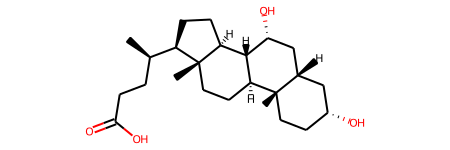

In [110]:
substructure_filter

SyntaxError: invalid syntax (3947773809.py, line 1)

In [122]:
[k for k,v in smiles_w_rdkit_obj.items()][1]

' '

In [111]:
# identify rows that contain substructure
matches = [k for k,v in smiles_w_rdkit_obj.items() if v.HasSubstructMatch(substructure_filter)]

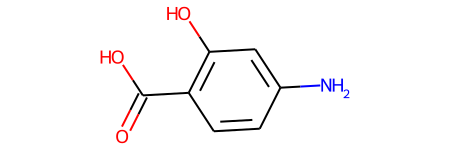

In [118]:
Chem.MolFromSmiles(matches[1])

In [117]:
matches

['C1(=C(C=C2C(=C1)C(=NC(=N2)N(CCCNC(C3CCCO3)=O)C)N)OC)OC.Cl',
 'C1=CC(=C(C=C1N)O)C(=O)O',
 'C1=CC=C(C(=C1)CC(=O)O)NC2=C(C=C(C=C2Cl)O)Cl',
 'CC(=CCC1=C(C=C(C2=C1O[C@@H](CC2=O)C3=CC=C(C=C3)O)O)O)C',
 'CCCC/C=C\\CCCCCCCC(=O)O',
 'CCCC[C@H]([C@@H](OC(C[C@H](C(O)=O)CC(O)=O)=O)[C@@H](OC(C[C@H](C(O)=O)CC(O)=O)=O)C[C@H](CCCCCC[C@@H](O)C[C@H](O)C(C)=O)C)C',
 'CCCCc1ccc(NC(=O)c2cc(OC)c(OC)c(OC)c2)cc1',
 'CCOc1ccc(C(O)=Nc2c(C)nc3ncnn3c2O)cc1OCC',
 'CCOc1ccc(CCN=C(O)c2cc3ccccc3oc2=O)cc1OCC',
 'CC[C@H](CN(C)[C@H]1Cc2c(C(C3)=O)[nH]c4c2cccc4)[C@H]3C1C(OC)=O',
 'CC[C@H](O)C[C@@H]1CC[C@@H](O1)[C@@H](C)C(O)=O',
 'CC[C@H](O)[C@H](C)\\C=C(/C)\\C=C\\[C@]1(O)[C@@H](C)C[C@@H](CC)C(=O)[C@@H]1C',
 'CC[C@H]1CC[C@H](NCC2=CC3=C(C=C2OC)[C@H]2C[C@H]2C(=O)N3C)[C@@H](N1)C1=CC=CC=C1',
 'CC[C@H]1CN2CCC3=C(NC4=CC=CC=C34)[C@H]2C[C@@H]1\\C(=C/OC)C(=O)OC',
 'CC[C@H]1CN2CC[C@]3([C@@H]2C[C@@H]1/C(=C\\OC)/C(=O)OC)C4=C(C=CC=C4O)NC3=O',
 'CC[C@H]1CN2CC[C@]3([C@@H]2C[C@@H]1\\C(=C/OC)C(=O)OC)C(O)=NC1=CC=CC=C31',
 'CC[C@H]1C[C@@H]

In [113]:
len(matches)

132

In [115]:
library_df_w_substruc = input_library[input_library['Smiles'].isin(matches)]

In [116]:
library_df_w_substruc

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history
68,CCMSLIB00000001615,C9.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[103.052773,63.640450],[104.056351,26.392759]...",splash10-0abl-0900000000-0900000000,mwang87,...,Positive,2019-07-23 10:41:19.0,cd7436c03e0c4e7f81d11bffa1bf56ea,null,JSPPQWVTDRBUIB-VGPDEBLWSA-N,JSPPQWVTDRBUIB-VGPDEBLWSA-N,C20H34O3,C20H34O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Pacificanone A', 'Ion_Sour..."
69,CCMSLIB00000001616,C9_1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[105.002411,15.557100],[105.069511,31.250740]...",splash10-0002-0009000000-0009000000,mwang87,...,Positive,2019-07-23 10:41:19.0,5d1f7d58b2ca483192bca11d5716f12c,null,JSPPQWVTDRBUIB-VGPDEBLWSA-N,JSPPQWVTDRBUIB-VGPDEBLWSA-N,C20H34O3,C20H34O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Pacificanone A', 'Ion_Sour..."
157,CCMSLIB00000001705,20130107_Jenia_Ger_Ecklonialactone_A_MH291-qb....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[157.028381,855.000000],[213.185425,4361.0000...",splash10-03di-0190000000-0190000000,mwang87,...,Positive,2021-03-18 16:30:20.0,efb37f6148ee45af9da3d0cc6ca5a9a2,null,GZNRNQVZDUCYFB-SOVGUPCDSA-N,GZNRNQVZDUCYFB-SOVGUPCDSA-N,C18H26O3,C18H26O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Ecklonialactone_A', 'Ion_S..."
2406,CCMSLIB00000478598,f.evgenia_glukhov/Standards/2223H4-6-Apratoxin...,0b7660244cae438ba272c2e843d67bc3,750,2,GNPS-LIBRARY,1,"[[269.390991,12658.000000],[327.942993,36220.0...",splash10-00di-0002790280-0002790280,evgenia_glukhov,...,Positive,2015-06-02 16:28:15.0,0b7660244cae438ba272c2e843d67bc3,null,KXUJXPZXILTXDA-CKIYSKEDSA-N,,C45H69N5O8S,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Apratoxin A', 'Ion_Source'..."
2407,CCMSLIB00000478599,f.evgenia_glukhov/Standards/2223H4-6-Apratoxin...,e9e12abcb4554868b7025cd9d4b8ac6c,760,2,GNPS-LIBRARY,1,"[[270.090759,7383.000000],[327.911499,4578.000...",splash10-00di-0003790250-0003790250,evgenia_glukhov,...,Positive,2015-06-02 16:29:40.0,e9e12abcb4554868b7025cd9d4b8ac6c,null,KXUJXPZXILTXDA-CKIYSKEDSA-N,,C45H69N5O8S,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Apratoxin A', 'Ion_Source'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570769,CCMSLIB00006114320,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,954,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[50.015400,29274.359375],[51.023201,33506.109...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570770,CCMSLIB00006114322,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,955,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[50.458698,723890.875000],[60.365501,681780.3...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570771,CCMSLIB00006114324,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,956,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[56.434799,3064934.000000],[78.581398,2568570...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570772,CCMSLIB00006114326,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,957,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[54.302200,3595174.000000],[92.811302,3677231...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584

In [114]:
has_dh_substruct = substruct_search_from_smiles(input_library, smiles_w_rdkit_obj, dh)
has_dh_substruct

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history
68,CCMSLIB00000001615,C9.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[103.052773,63.640450],[104.056351,26.392759]...",splash10-0abl-0900000000-0900000000,mwang87,...,Positive,2019-07-23 10:41:19.0,cd7436c03e0c4e7f81d11bffa1bf56ea,null,JSPPQWVTDRBUIB-VGPDEBLWSA-N,JSPPQWVTDRBUIB-VGPDEBLWSA-N,C20H34O3,C20H34O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Pacificanone A', 'Ion_Sour..."
69,CCMSLIB00000001616,C9_1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[105.002411,15.557100],[105.069511,31.250740]...",splash10-0002-0009000000-0009000000,mwang87,...,Positive,2019-07-23 10:41:19.0,5d1f7d58b2ca483192bca11d5716f12c,null,JSPPQWVTDRBUIB-VGPDEBLWSA-N,JSPPQWVTDRBUIB-VGPDEBLWSA-N,C20H34O3,C20H34O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Pacificanone A', 'Ion_Sour..."
157,CCMSLIB00000001705,20130107_Jenia_Ger_Ecklonialactone_A_MH291-qb....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[157.028381,855.000000],[213.185425,4361.0000...",splash10-03di-0190000000-0190000000,mwang87,...,Positive,2021-03-18 16:30:20.0,efb37f6148ee45af9da3d0cc6ca5a9a2,null,GZNRNQVZDUCYFB-SOVGUPCDSA-N,GZNRNQVZDUCYFB-SOVGUPCDSA-N,C18H26O3,C18H26O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Ecklonialactone_A', 'Ion_S..."
2406,CCMSLIB00000478598,f.evgenia_glukhov/Standards/2223H4-6-Apratoxin...,0b7660244cae438ba272c2e843d67bc3,750,2,GNPS-LIBRARY,1,"[[269.390991,12658.000000],[327.942993,36220.0...",splash10-00di-0002790280-0002790280,evgenia_glukhov,...,Positive,2015-06-02 16:28:15.0,0b7660244cae438ba272c2e843d67bc3,null,KXUJXPZXILTXDA-CKIYSKEDSA-N,,C45H69N5O8S,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Apratoxin A', 'Ion_Source'..."
2407,CCMSLIB00000478599,f.evgenia_glukhov/Standards/2223H4-6-Apratoxin...,e9e12abcb4554868b7025cd9d4b8ac6c,760,2,GNPS-LIBRARY,1,"[[270.090759,7383.000000],[327.911499,4578.000...",splash10-00di-0003790250-0003790250,evgenia_glukhov,...,Positive,2015-06-02 16:29:40.0,e9e12abcb4554868b7025cd9d4b8ac6c,null,KXUJXPZXILTXDA-CKIYSKEDSA-N,,C45H69N5O8S,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Apratoxin A', 'Ion_Source'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570769,CCMSLIB00006114320,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,954,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[50.015400,29274.359375],[51.023201,33506.109...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570770,CCMSLIB00006114322,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,955,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[50.458698,723890.875000],[60.365501,681780.3...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570771,CCMSLIB00006114324,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,956,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[56.434799,3064934.000000],[78.581398,2568570...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570772,CCMSLIB00006114326,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,957,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[54.302200,3595174.000000],[92.811302,3677231...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584

## substructure search for allegra

In [53]:
# substructure search for allegra 05/09/2022

# dihydroxy-BA core structure (CDCA)
CDCA = 'C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)C'

# trihydroxy-BA core structure (Cholic acid)
cholic_acid = 'C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)O)C'

# tetrahydroxy-BA core structure (THBA)
THBA = 'CC(CCC=C(C)C(=O)O)C1CCC2C1(C(CC3C2C(C(C4C3(CCC(C4)O)C)O)O)O)C'
THBA:    OC(CC[C@@H](C)C1CC[C@@]2([H])C3[C@H](O)[C@H](O)[C@]4([H])C[C@H](O)CC[C@]4(C)[C@@]3([H])C[C@H](O)[C@@]21C

# mono-hydroxylated (lithocholic acid)     
lithocholic_acid = 'O=C(O)CC[C@H]([C@H]1CC[C@@H]2[C@]1(C)CC[C@H]4[C@H]2CC[C@@H]3C[C@H](O)CC[C@@]34C)C'

In [88]:
dh = 'C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)C'

In [89]:
dh_mol = Chem.MolFromSmiles(dh)

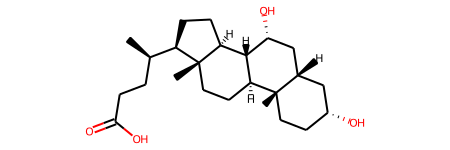

In [90]:
dh_mol

In [92]:
new_tca = 'O=CCC[C@@H](C)C1CC[C@@]2([H])C3C(O)C[C@]4([H])CC(O)CC[C@]4(C)[C@@]3([H])CC(O)[C@@]21C'

In [93]:
new_tca_mol = Chem.MolFromSmiles(new_tca)

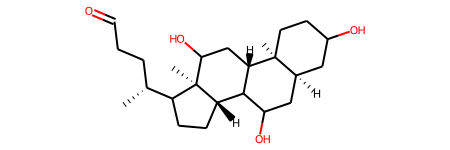

In [94]:
new_tca_mol

In [85]:
tca = 'CC(CCC(=O)NCCS(=O)(=O)O)C1CCC2C1(C(CC3C2C(CC4C3(CCC(C4)O)C)O)O)C'

In [96]:
tca_mol = Chem.MolFromSmiles(tca)

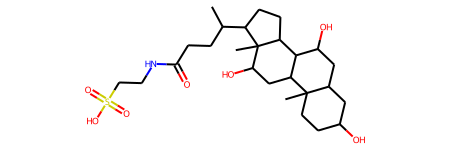

In [87]:
tca_mol

In [44]:
# substructure search: CDCA
has_CDCA_substruct = substruct_search_from_smiles(input_library_spec_json, mol_from_smiles_df, CDCA)

In [45]:
has_CDCA_substruct

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history
68,CCMSLIB00000001615,C9.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[103.052773,63.640450],[104.056351,26.392759]...",splash10-0abl-0900000000-0900000000,mwang87,...,Positive,2019-07-23 10:41:19.0,cd7436c03e0c4e7f81d11bffa1bf56ea,null,JSPPQWVTDRBUIB-VGPDEBLWSA-N,JSPPQWVTDRBUIB-VGPDEBLWSA-N,C20H34O3,C20H34O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Pacificanone A', 'Ion_Sour..."
69,CCMSLIB00000001616,C9_1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[105.002411,15.557100],[105.069511,31.250740]...",splash10-0002-0009000000-0009000000,mwang87,...,Positive,2019-07-23 10:41:19.0,5d1f7d58b2ca483192bca11d5716f12c,null,JSPPQWVTDRBUIB-VGPDEBLWSA-N,JSPPQWVTDRBUIB-VGPDEBLWSA-N,C20H34O3,C20H34O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Pacificanone A', 'Ion_Sour..."
157,CCMSLIB00000001705,20130107_Jenia_Ger_Ecklonialactone_A_MH291-qb....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[157.028381,855.000000],[213.185425,4361.0000...",splash10-03di-0190000000-0190000000,mwang87,...,Positive,2021-03-18 16:30:20.0,efb37f6148ee45af9da3d0cc6ca5a9a2,null,GZNRNQVZDUCYFB-SOVGUPCDSA-N,GZNRNQVZDUCYFB-SOVGUPCDSA-N,C18H26O3,C18H26O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Ecklonialactone_A', 'Ion_S..."
2406,CCMSLIB00000478598,f.evgenia_glukhov/Standards/2223H4-6-Apratoxin...,0b7660244cae438ba272c2e843d67bc3,750,2,GNPS-LIBRARY,1,"[[269.390991,12658.000000],[327.942993,36220.0...",splash10-00di-0002790280-0002790280,evgenia_glukhov,...,Positive,2015-06-02 16:28:15.0,0b7660244cae438ba272c2e843d67bc3,null,KXUJXPZXILTXDA-CKIYSKEDSA-N,,C45H69N5O8S,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Apratoxin A', 'Ion_Source'..."
2407,CCMSLIB00000478599,f.evgenia_glukhov/Standards/2223H4-6-Apratoxin...,e9e12abcb4554868b7025cd9d4b8ac6c,760,2,GNPS-LIBRARY,1,"[[270.090759,7383.000000],[327.911499,4578.000...",splash10-00di-0003790250-0003790250,evgenia_glukhov,...,Positive,2015-06-02 16:29:40.0,e9e12abcb4554868b7025cd9d4b8ac6c,null,KXUJXPZXILTXDA-CKIYSKEDSA-N,,C45H69N5O8S,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Apratoxin A', 'Ion_Source'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570769,CCMSLIB00006114320,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,954,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[50.015400,29274.359375],[51.023201,33506.109...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570770,CCMSLIB00006114322,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,955,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[50.458698,723890.875000],[60.365501,681780.3...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570771,CCMSLIB00006114324,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,956,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[56.434799,3064934.000000],[78.581398,2568570...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570772,CCMSLIB00006114326,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,957,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[54.302200,3595174.000000],[92.811302,3677231...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584

In [46]:
# substructure search: cholic acid
has_cholic_acid_substruct = substruct_search_from_smiles(input_library_spec_json, mol_from_smiles_df, cholic_acid)

In [47]:
has_cholic_acid_substruct

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history
68,CCMSLIB00000001615,C9.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[103.052773,63.640450],[104.056351,26.392759]...",splash10-0abl-0900000000-0900000000,mwang87,...,Positive,2019-07-23 10:41:19.0,cd7436c03e0c4e7f81d11bffa1bf56ea,null,JSPPQWVTDRBUIB-VGPDEBLWSA-N,JSPPQWVTDRBUIB-VGPDEBLWSA-N,C20H34O3,C20H34O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Pacificanone A', 'Ion_Sour..."
69,CCMSLIB00000001616,C9_1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[105.002411,15.557100],[105.069511,31.250740]...",splash10-0002-0009000000-0009000000,mwang87,...,Positive,2019-07-23 10:41:19.0,5d1f7d58b2ca483192bca11d5716f12c,null,JSPPQWVTDRBUIB-VGPDEBLWSA-N,JSPPQWVTDRBUIB-VGPDEBLWSA-N,C20H34O3,C20H34O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Pacificanone A', 'Ion_Sour..."
157,CCMSLIB00000001705,20130107_Jenia_Ger_Ecklonialactone_A_MH291-qb....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[157.028381,855.000000],[213.185425,4361.0000...",splash10-03di-0190000000-0190000000,mwang87,...,Positive,2021-03-18 16:30:20.0,efb37f6148ee45af9da3d0cc6ca5a9a2,null,GZNRNQVZDUCYFB-SOVGUPCDSA-N,GZNRNQVZDUCYFB-SOVGUPCDSA-N,C18H26O3,C18H26O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Ecklonialactone_A', 'Ion_S..."
2406,CCMSLIB00000478598,f.evgenia_glukhov/Standards/2223H4-6-Apratoxin...,0b7660244cae438ba272c2e843d67bc3,750,2,GNPS-LIBRARY,1,"[[269.390991,12658.000000],[327.942993,36220.0...",splash10-00di-0002790280-0002790280,evgenia_glukhov,...,Positive,2015-06-02 16:28:15.0,0b7660244cae438ba272c2e843d67bc3,null,KXUJXPZXILTXDA-CKIYSKEDSA-N,,C45H69N5O8S,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Apratoxin A', 'Ion_Source'..."
2407,CCMSLIB00000478599,f.evgenia_glukhov/Standards/2223H4-6-Apratoxin...,e9e12abcb4554868b7025cd9d4b8ac6c,760,2,GNPS-LIBRARY,1,"[[270.090759,7383.000000],[327.911499,4578.000...",splash10-00di-0003790250-0003790250,evgenia_glukhov,...,Positive,2015-06-02 16:29:40.0,e9e12abcb4554868b7025cd9d4b8ac6c,null,KXUJXPZXILTXDA-CKIYSKEDSA-N,,C45H69N5O8S,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Apratoxin A', 'Ion_Source'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566759,CCMSLIB00000425673,hmdb_intermediate.mgf,d2a6c58c3dbc40b29f9f3ab532287b0f,645,2,HMDB,1,"[[41.363, 10.347], [43.33, 30.556], [45.321, 1...",splash10-066r-9000000000-9000000000,mwang87,...,Positive,2015-02-20 17:07:30.0,d2a6c58c3dbc40b29f9f3ab532287b0f,null,FBPFZTCFMRRESA-JGWLITMVSA-N,FBPFZTCFMRRESA-JGWLITMVSA-N,C6H14O6,C6H14O6,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'HMDB:HMDB00247-422 Sorbito...
567286,CCMSLIB00000426200,hmdb_intermediate.mgf,d2a6c58c3dbc40b29f9f3ab532287b0f,1172,2,HMDB,1,"[[55.244, 5.419], [57.211, 8.601], [61.193, 9....",splash10-017j-8900000000-8900000000,mwang87,...,Positive,2015-02-20 17:07:30.0,d2a6c58c3dbc40b29f9f3ab532287b0f,null,FBPFZTCFMRRESA-JGWLITMVSA-N,FBPFZTCFMRRESA-JGWLITMVSA-N,C6H14O6,C6H14O6,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'HMDB:HMDB00247-421 Sorbito...
567452,CCMSLIB00000426366,hmdb_intermediate.mgf,d2a6c58c3dbc40b29f9f3ab532287b0f,1338,2,HMDB,1,"[[61.0, 86.5857533202], [69.0, 100.0], [73.0, ...",splash10-02t9-9000000000-9000000000,mwang87,...,Positive,2015-02-20 17:07:30.0,d2a6c58c3dbc40b29f9f3ab532287b0f,null,HEBKCHPVOIAQTA-NGQZWQHPSA-N,HEBKCHPVOIAQTA-NGQZWQHPSA-N,C5H12O5,C5H12O5,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'HMDB:HMDB02917-2162 D-Xyli...
567753,CCMSLIB00000426667,hmdb_intermediate.mgf,d2a6c58c3dbc40b29f9f3ab532287b0f,1639,2,HMDB,1,"[[41.355, 47.137], [43.307, 100.0], [45.298, 3...",spl

In [48]:
# substructure search: THBA
has_THBA_substruct = substruct_search_from_smiles(input_library_spec_json, mol_from_smiles_df, THBA)

In [49]:
has_THBA_substruct

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history


In [54]:
# substructure search: lithocholic acid
has_lithocholic_acid_substruct = substruct_search_from_smiles(input_library_spec_json, mol_from_smiles_df, lithocholic_acid)

In [55]:
has_lithocholic_acid_substruct

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history
54,CCMSLIB00000001601,20121201_PAVL_Ger_ApratoxinA_MH_840_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[242.828094,17729.000000],[269.571777,53626.0...",splash10-00di-0003791160-0003791160,mwang87,...,Positive,2019-07-23 10:41:15.0,170af6f130d94c45b15465d02f2fb37e,null,KXUJXPZXILTXDA-JHMIWIOGSA-N,KXUJXPZXILTXDA-JHMIWIOGSA-N,C45H69N5O8S,C45H69N5O8S,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Apratoxin A', 'Ion_Source'..."
56,CCMSLIB00000001603,20121201_PAVL_Ger_ApratoxinA_MNa_862_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[330.985535,124250.000000],[331.856628,10035....",splash10-08fu-0000050590-0000050590,mwang87,...,Positive,2019-07-23 10:41:16.0,15a4f1a167c94d7a8af285d2ec682a0a,null,KXUJXPZXILTXDA-JHMIWIOGSA-N,KXUJXPZXILTXDA-JHMIWIOGSA-N,C45H69N5O8S,C45H69N5O8S,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Apratoxin A', 'Ion_Source'..."
68,CCMSLIB00000001615,C9.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[103.052773,63.640450],[104.056351,26.392759]...",splash10-0abl-0900000000-0900000000,mwang87,...,Positive,2019-07-23 10:41:19.0,cd7436c03e0c4e7f81d11bffa1bf56ea,null,JSPPQWVTDRBUIB-VGPDEBLWSA-N,JSPPQWVTDRBUIB-VGPDEBLWSA-N,C20H34O3,C20H34O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Pacificanone A', 'Ion_Sour..."
69,CCMSLIB00000001616,C9_1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[105.002411,15.557100],[105.069511,31.250740]...",splash10-0002-0009000000-0009000000,mwang87,...,Positive,2019-07-23 10:41:19.0,5d1f7d58b2ca483192bca11d5716f12c,null,JSPPQWVTDRBUIB-VGPDEBLWSA-N,JSPPQWVTDRBUIB-VGPDEBLWSA-N,C20H34O3,C20H34O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Pacificanone A', 'Ion_Sour..."
157,CCMSLIB00000001705,20130107_Jenia_Ger_Ecklonialactone_A_MH291-qb....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[157.028381,855.000000],[213.185425,4361.0000...",splash10-03di-0190000000-0190000000,mwang87,...,Positive,2021-03-18 16:30:20.0,efb37f6148ee45af9da3d0cc6ca5a9a2,null,GZNRNQVZDUCYFB-SOVGUPCDSA-N,GZNRNQVZDUCYFB-SOVGUPCDSA-N,C18H26O3,C18H26O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Ecklonialactone_A', 'Ion_S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570769,CCMSLIB00006114320,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,954,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[50.015400,29274.359375],[51.023201,33506.109...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570770,CCMSLIB00006114322,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,955,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[50.458698,723890.875000],[60.365501,681780.3...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570771,CCMSLIB00006114324,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,956,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[56.434799,3064934.000000],[78.581398,2568570...",null-null-null-null,mwang87,...,Positive,2021-04-15 16:26:46.0,04aea32d6ccf4240b8b5131584ae6413,null,ZYGHJZDHTFUPRJ-UHFFFAOYSA-N,,C9H6O2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Coumarin - 30.0 eV', 'Ion_..."
570772,CCMSLIB00006114326,birmingham_pos.mgf,04aea32d6ccf4240b8b5131584ae6413,957,2,BIRMINGHAM-UHPLC-MS-POS,1,"[[54.302200,3595174.000000],[92.811302,3677231...",null-null-null-null,mwang87,...,Positive

In [12]:
def Mol_From_Smiles_in_Library(library_df):
    
    input_library = library_df
    
    # identifies all SMILES in library dataframe
    smiles_list = input_library[input_library['Smiles'].notnull()]['Smiles'].unique()
    
    mol_from_smiles = [Chem.MolFromSmiles(AZsmiles) for AZsmiles in smiles_list]
    
    # matches SMILES with rdkit molecular object
    smiles_and_rdkit_obj = dict(zip(np.unique(smiles_list),mol_from_smiles))
    
    # exclude dataframe rows that do not contain valid SMILES
    rem_list = [k for k,v in smiles_and_rdkit_obj.items() if v == None]
    
    smiles_and_rdkit_obj_dropNone = {key:val for key, val in smiles_and_rdkit_obj.items() if key not in rem_list}
    
    return smiles_and_rdkit_obj_dropNone

In [13]:
Mol_From_Smiles_in_Library_list = Mol_From_Smiles_in_Library(input_library_spec_json)

In [17]:
len(Mol_From_Smiles_in_Library_list)

35803

In [15]:
smiles_list = input_library[input_library['Smiles'].notnull()]['Smiles'].unique()

mol_from_smiles = [Chem.MolFromSmiles(AZsmiles) for AZsmiles in smiles_list]

# matches SMILES with rdkit molecular object
smiles_and_rdkit_obj = dict(zip(np.unique(smiles_list),mol_from_smiles))

# exclude dataframe rows that do not contain valid SMILES
rem_list = [k for k,v in smiles_and_rdkit_obj.items() if v == None]

smiles_and_rdkit_obj_dropNone = {key:val for key, val in smiles_and_rdkit_obj.items() if key not in rem_list}

In [18]:
len(smiles_and_rdkit_obj_dropNone)

35803

In [122]:
input_library_spec_json['Smiles'][18050
                                 ]

'COC(=O)C1C(OC2=C(O)C=CC(\\C=C\\C(=O)OC(CC3=CC(O)=C(O)C=C3)C(O)=O)=C12)C4=CC=C(O)C(O)=C4'

In [11]:
input_library = input_library_spec_json
substructure_filter = Chem.MolFromSmiles('CCC')

## Produce subsection of data by exact SMILES matches

In [8]:
exact_match_list = ['CCCCCC(=O)NCC(=O)O',
                            'OC1=CC=C(\\C=C2\\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\\C(=C/C4=CC=C(O)C=C4)C3=O)=C3C4=C(C=CC=C4)N=C23)C=C1',
                           'COC(=O)C1C(OC2=C(O)C=CC(\\C=C\\C(=O)OC(CC3=CC(O)=C(O)C=C3)C(O)=O)=C12)C4=CC=C(O)C(O)=C4']

In [9]:
exact_match_list_filter = [Chem.MolFromSmiles(AZsmiles) for AZsmiles in exact_match_list]

In [10]:
exact_match_list_filter

In [11]:
smiles_list = input_library_smallest_new[input_library_smallest_new['Smiles'].notnull()]['Smiles'].unique()

mol_from_smiles = [Chem.MolFromSmiles(AZsmiles) for AZsmiles in smiles_list]

# matches SMILES with rdkit molecular object
smiles_and_rdkit_obj = dict(zip(np.unique(smiles_list),mol_from_smiles))

# exclude dataframe rows that do not contain valid SMILES
rem_list = [k for k,v in smiles_and_rdkit_obj.items() if v == None]

smiles_and_rdkit_obj_dropNone = {key:val for key, val in smiles_and_rdkit_obj.items() if key not in rem_list}

In [20]:
exact_match_list = [k for k in smiles_and_rdkit_obj_dropNone.keys() for exact_match in exact_match_list if k == exact_match]

In [21]:
exact_match_list

['OC1=CC=C(\\C=C2\\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\\C(=C/C4=CC=C(O)C=C4)C3=O)=C3C4=C(C=CC=C4)N=C23)C=C1']

In [22]:
library_spec_with_exact_match = input_library_smallest_new[input_library_smallest_new['Smiles'].isin(exact_match_list)]

In [23]:
library_spec_with_exact_match

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history
index,,,,,,,,,,,,,,,,,,,,,
3,CCMSLIB00000001550,20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[343.896484,142503.000000],[345.458496,67939....",splash10-0002-0000190000-0000190000,mwang87,...,Positive,2019-07-23 10:38:26.0,ca48cf7bc6644f5e89f98d62f114dfea,NaN,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO-RPCRKUJJSA-N,C36H20N2O4,C36H20N2O4,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Scytonemin', 'Ion_Source':..."
551,CCMSLIB00000070263,1B9_Scytonemin_MH_545.mzXML,6c7cf0ddbcd944488b3f58728dc48405,2550,2,GNPS-LIBRARY,1,"[[160.504257,164.000000],[164.510040,164.00000...",splash10-0002-0001390000-0001390000,tal_lk,...,Positive,2019-07-23 10:41:37.0,02875ea776fd4074aa17833c9f35dfe7,NaN,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO-RPCRKUJJSA-N,C36H20N2O4,C36H20N2O4,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Scytonemin', 'Ion_Source':..."


In [ ]:
matches_list = [k for k,v in smiles_and_rdkit_obj_dropNone.items() 
           for exact_match in exact_match_list_filter if v == exact_match]

In [33]:
matches_list = [k for k,v in smiles_and_rdkit_obj_dropNone.items() 
           for exact_match in exact_match_list if v == exact_match]

In [34]:
matches_list

[]

In [130]:
library_spec_with_exact_match = input_library[input_library['Smiles'].isin(matches_list)]

In [131]:
library_spec_with_exact_match

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history
157,CCMSLIB00000001705,20130107_Jenia_Ger_Ecklonialactone_A_MH291-qb....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[157.028381,855.000000],[213.185425,4361.0000...",splash10-03di-0190000000-0190000000,mwang87,...,Positive,2021-03-18 16:30:20.0,efb37f6148ee45af9da3d0cc6ca5a9a2,null,GZNRNQVZDUCYFB-SOVGUPCDSA-N,GZNRNQVZDUCYFB-SOVGUPCDSA-N,C18H26O3,C18H26O3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Ecklonialactone_A', 'Ion_S..."
297,CCMSLIB00000006854,Triacetylfuscarinine_C_853_MS2_3.mzXML,92339c9ea14140fe82815c02988e5abb,1,2,GNPS-LIBRARY,1,"[[267.000000,0.289740],[285.181824,1.800511],[...",splash10-00ku-0040091260-0040091260,mwang87,...,Positive,2021-03-18 16:41:29.0,22bc4c122a2f45ec9d39e63a89ba7272,null,PJECCKYLTMQOCP-IJGXQDLJSA-Q,PJECCKYLTMQOCP-IJGXQDLJSA-Q,C39H63FeN6O15+3,C39H63FeN6O15+3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Triacetylfusarinine C', 'I..."
298,CCMSLIB00000006855,Triacetylfuscarinine_C_Na_875_MS2.mzXML,92339c9ea14140fe82815c02988e5abb,1,2,GNPS-LIBRARY,1,"[[279.100555,14.764845],[289.121582,19.332903]...",splash10-0006-0001290110-0001290110,mwang87,...,Positive,2021-03-18 16:41:31.0,513701b1ffe24cb6b8a5d00932acb2b7,null,PJECCKYLTMQOCP-IJGXQDLJSA-Q,PJECCKYLTMQOCP-IJGXQDLJSA-Q,C39H63FeN6O15+3,C39H63FeN6O15+3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Triacetylfusarinine C', 'I..."
299,CCMSLIB00000006856,Triacetylfuscarinine_C_K__891MS2.mzXML,92339c9ea14140fe82815c02988e5abb,1,2,GNPS-LIBRARY,1,"[[251.084473,3.544360],[261.267212,2.076733],[...",splash10-0a4i-0001329320-0001329320,mwang87,...,Positive,2021-03-18 16:41:32.0,11d4d24878ec432b8a57b85685ecfaa5,null,PJECCKYLTMQOCP-IJGXQDLJSA-Q,PJECCKYLTMQOCP-IJGXQDLJSA-Q,C39H63FeN6O15+3,C39H63FeN6O15+3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Triacetylfusarinine C', 'I..."
1920,CCMSLIB00000424826,f.MSV000078568/spectrum/GNPS_Dorrestein_Gerwic...,bf798a49c5fa4745bdd11d1c331ddd2a,1451,2,GNPS-LIBRARY,1,"[[66.008423,172.000000],[74.652702,204.000000]...",splash10-0a4i-1649170600-1649170600,tal_lk,...,Positive,2015-02-03 17:18:59.0,bf798a49c5fa4745bdd11d1c331ddd2a,null,FZTCTTODSSJQQB-XKDMFOEASA-N,,C40H59N5O7,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Carmabin B', 'Ion_Source':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665822,CCMSLIB00006123251,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,4451,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[69.602303,19665.929688],[78.959000,1005263.0...",null-null-null-null,mwang87,...,Negative,2021-04-15 16:27:10.0,ac575833873943cdb89946fc9dec1851,null,GSXOAOHZAIYLCY-HSUXUTPPSA-N,,C6H13O9P,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'fructose 6-phosphate - 30....
668174,CCMSLIB00006126414,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,6803,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[51.023998,10728.950195],[55.018501,33021.570...",null-null-null-null,mwang87,...,Negative,2021-04-15 16:27:10.0,ac575833873943cdb89946fc9dec1851,null,SEWFWJUQVJHATO-PUVWEJBASA-N,,C12H22O11,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'D-Turanose - 40.0 eV', 'Io..."
668175,CCMSLIB00006126415,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,6804,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[50.253399,7688.080078],[55.018600,30471.3691...",null-null-null-null,mwang87,...,Negative,2021-04-15 16:27:10.0,ac575833873943cdb89946fc9dec1851,null,SEWFWJUQVJHATO-PUVWEJBASA-N,,C12H22O11,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'D-Turanose - 40.0 eV', 'Io..."
668176,CCMSLIB00006126416,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,6805,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[52.376999,9076.62988

## Produce subsection of data by spectrum ID

In [22]:
spectrum_ID_search = input_library_spec_json.spectrum_id[:10].to_list()

In [24]:
input_library_spec_json_by_spec_ID = input_library_spec_json.loc[input_library_spec_json['spectrum_id'].isin(spectrum_ID_search)]

In [25]:
input_library_spec_json_by_spec_ID

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history
0,CCMSLIB00000001547,130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[289.286377,8068.000000],[295.545288,22507.00...",splash10-0w2a-0001282259-0001282259,mwang87,...,Positive,2019-10-30 21:18:25.0,aa87bf9cd0784df9956753f435c32434,null,IYDKWWDUBYWQGF-NNAZGLEUSA-N,,C48H72N10O12,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': '3-Des-Microcystein_LR', 'I..."
1,CCMSLIB00000001548,20111105_Anada_Ger_HoiamideB_MH940_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[278.049927,35793.000000],[278.957642,47593.0...",splash10-00dl-0000011189-0000011189,mwang87,...,Positive,2019-06-04 02:55:49.0,cd4ed49954b94767a54918c340d18fa1,null,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN-ZNCJFREWSA-N,C45H73N5O10S3,C45H73N5O10S3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Hoiamide B', 'Ion_Source':..."
2,CCMSLIB00000001549,20111105_Jenia_Ger_MalyngamideC_MH_456_qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[128.838745,8064.000000],[132.075684,8080.000...",splash10-00di-0000900000-0000900000,mwang87,...,Positive,2021-03-18 16:28:20.0,48c1656fa4464fea93b71bfd79e0faa5,null,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE-NSCMQRKRSA-N,C24H38ClNO5,C24H38ClNO5,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Malyngamide C', 'Ion_Sourc..."
3,CCMSLIB00000001550,20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[343.896484,142503.000000],[345.458496,67939....",splash10-0002-0000190000-0000190000,mwang87,...,Positive,2019-07-23 10:38:26.0,ca48cf7bc6644f5e89f98d62f114dfea,null,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO-RPCRKUJJSA-N,C36H20N2O4,C36H20N2O4,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Scytonemin', 'Ion_Source':..."
4,CCMSLIB00000001551,A1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[101.015465,34.201859],[101.059807,14.903370]...",splash10-03di-0910000000-0910000000,mwang87,...,Positive,2014-02-04 17:56:31.0,d14a5843653040ba9fa2c4376f2be358,null,,,,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Salinisporamide A', 'Ion_S..."
5,CCMSLIB00000001552,20120412_PAVL_FT_Hectochlorin_MCl37H_667_qb.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[200.205383,7905.953125],[201.312088,2282.589...",splash10-0a4i-0000119000-0000119000,mwang87,...,Positive,2019-11-04 11:35:10.0,a3612cf24ba246e5979778166475dc98,null,USXIYWCPCGVOKF-LERJCCFDSA-N,,C27H34Cl2N2O9S2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Hectochlorin', 'Ion_Source..."
6,CCMSLIB00000001553,20120412_PAVL_FT_Hectochlorin_MCl37Na_689_qb.1...,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[264.268188,44.800793],[336.234344,9.785302],...",splash10-0udi-0000009000-0000009000,mwang87,...,Positive,2021-03-18 16:28:22.0,72b0d8d7347441ef8e38a600f2182767,null,USXIYWCPCGVOKF-NOENWEJRSA-N,USXIYWCPCGVOKF-NOENWEJRSA-N,C27H34Cl2N2O9S2,C27H34Cl2N2O9S2,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Hectochlorin', 'Ion_Source..."
7,CCMSLIB00000001554,A2.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[100.112305,26031.130859],[101.115685,2196.75...",splash10-00or-6645935000-6645935000,mwang87,...,Positive,2019-07-23 10:41:12.0,e8fb9c9313c645b993db19015297289e,null,WCNJVJCYRBJSLC-BCJYPDSRSA-N,WCNJVJCYRBJSLC-BCJYPDSRSA-N,C56H82N8O11,C56H82N8O11,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Cyclomarin A', 'Ion_Source..."
8,CCMSLIB00000001555,20120412_PAVL_FT_Hectochlorin_MH_665_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[190.095718,122.539017],[200.200897,3540.4433...",splash10-0a4i-0000119000-000

In [ ]:
exact_match_list = ['CCCCCC(=O)NCC(=O)O',
                            'OC1=CC=C(\\C=C2\\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\\C(=C/C4=CC=C(O)C=C4)C3=O)=C3C4=C(C=CC=C4)N=C23)C=C1',
                           'COC(=O)C1C(OC2=C(O)C=CC(\\C=C\\C(=O)OC(CC3=CC(O)=C(O)C=C3)C(O)=O)=C12)C4=CC=C(O)C(O)=C4']

In [93]:
# identifies all SMILES in library dataframe
start = time.time()

smiles_list = input_library[input_library['Smiles'].notnull()]['Smiles'].unique()

end = time.time()

total_time = end - start
print("\n"+ str(total_time))


3.3746888637542725


In [94]:
# identifies all SMILES in library dataframe
start = time.time()

mol_from_smiles = [Chem.MolFromSmiles(AZsmiles) for AZsmiles in smiles_list]

end = time.time()

total_time = end - start
print("\n"+ str(total_time))


25.345582485198975


In [95]:
# identifies all SMILES in library dataframe
start = time.time()

smiles_and_rdkit_obj = dict(zip(np.unique(smiles_list),mol_from_smiles))

end = time.time()

total_time = end - start
print("\n"+ str(total_time))


0.15544581413269043


In [96]:
start = time.time()

rem_list = [k for k,v in smiles_and_rdkit_obj.items() if v == None]

end = time.time()

total_time = end - start
print("\n"+ str(total_time))


0.03876996040344238


In [97]:
start = time.time()

smiles_and_rdkit_obj_dropNone = {key:val for key, val in smiles_and_rdkit_obj.items() if key not in rem_list}

end = time.time()

total_time = end - start
print("\n"+ str(total_time))


0.12569713592529297


In [98]:
start = time.time()

matches = [k for k,v in smiles_and_rdkit_obj_dropNone.items() if v.HasSubstructMatch(substructure_filter)]

end = time.time()

total_time = end - start
print("\n"+ str(total_time))


0.6071314811706543


In [99]:
start = time.time()

library_spec_with_substruc = input_library[input_library['Smiles'].isin(matches)]

end = time.time()

total_time = end - start
print("\n"+ str(total_time))


1.8753104209899902


In [ ]:
# identifies all SMILES in library dataframe
smiles_list = input_library[input_library['Smiles'].notnull()]['Smiles'].unique()

mol_from_smiles = [Chem.MolFromSmiles(AZsmiles) for AZsmiles in smiles_list]

# matches SMILES with rdkit molecular object
smiles_and_rdkit_obj = dict(zip(np.unique(smiles_list),mol_from_smiles))

# exclude dataframe rows that do not contain valid SMILES
rem_list = [k for k,v in smiles_and_rdkit_obj.items() if v == None]

smiles_and_rdkit_obj_dropNone = {key:val for key, val in smiles_and_rdkit_obj.items() if key not in rem_list}


# identify rows that contain substructure
matches = [k for k,v in smiles_and_rdkit_obj_dropNone.items() if v.HasSubstructMatch(substructure_filter)]

library_spec_with_substruc = input_library[input_library['Smiles'].isin(matches)]

In [86]:
def inchikey_query(library_spec,substruct_search):
    
    input_library = library_spec
    
    substructure_filter = substruct_search
    
    # identifies all SMILES in library dataframe
    smiles_list = input_library[input_library['Smiles'].notnull()]['Smiles'].unique()
    
    mol_from_smiles = [Chem.MolFromSmiles(AZsmiles) for AZsmiles in smiles_list]
    
    # matches SMILES with rdkit molecular object
    smiles_and_rdkit_obj = dict(zip(np.unique(smiles_list),mol_from_smiles))
    
    # exclude dataframe rows that do not contain valid SMILES
    rem_list = [k for k,v in smiles_and_rdkit_obj.items() if v == None]
    
    smiles_and_rdkit_obj_dropNone = {key:val for key, val in smiles_and_rdkit_obj.items() if key not in rem_list}
    
    
    # identify rows that contain substructure
    matches = [k for k,v in smiles_and_rdkit_obj_dropNone.items() if v.HasSubstructMatch(substructure_filter)]
    
    library_spec_with_substruc = input_library[input_library['Smiles'].isin(matches)]
    
    return library_spec_with_substruc

In [87]:
substructure_filter = Chem.MolFromSmiles('CCC')

In [88]:
start = time.time()

= inchikey_query(input_library_spec_json, substructure_filter)

# Grab Currrent Time After Running the Code
end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
print("\n"+ str(total_time))


32.83470320701599


In [89]:
start = time.time()

inchikey_query_output = inchikey_query(input_library_spec_json, substructure_filter)

# Grab Currrent Time After Running the Code
end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
print("\n"+ str(total_time))


32.17785167694092


In [90]:
inchikey_query_output

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history
0,CCMSLIB00000001547,130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[289.286377,8068.000000],[295.545288,22507.00...",splash10-0w2a-0001282259-0001282259,mwang87,...,Positive,2019-10-30 21:18:25.0,aa87bf9cd0784df9956753f435c32434,null,IYDKWWDUBYWQGF-NNAZGLEUSA-N,,C48H72N10O12,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': '3-Des-Microcystein_LR', 'I..."
1,CCMSLIB00000001548,20111105_Anada_Ger_HoiamideB_MH940_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[278.049927,35793.000000],[278.957642,47593.0...",splash10-00dl-0000011189-0000011189,mwang87,...,Positive,2019-06-04 02:55:49.0,cd4ed49954b94767a54918c340d18fa1,null,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN-ZNCJFREWSA-N,C45H73N5O10S3,C45H73N5O10S3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Hoiamide B', 'Ion_Source':..."
4,CCMSLIB00000001551,A1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[101.015465,34.201859],[101.059807,14.903370]...",splash10-03di-0910000000-0910000000,mwang87,...,Positive,2014-02-04 17:56:31.0,d14a5843653040ba9fa2c4376f2be358,null,,,,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Salinisporamide A', 'Ion_S..."
5,CCMSLIB00000001552,20120412_PAVL_FT_Hectochlorin_MCl37H_667_qb.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[200.205383,7905.953125],[201.312088,2282.589...",splash10-0a4i-0000119000-0000119000,mwang87,...,Positive,2019-11-04 11:35:10.0,a3612cf24ba246e5979778166475dc98,null,USXIYWCPCGVOKF-LERJCCFDSA-N,,C27H34Cl2N2O9S2,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Hectochlorin', 'Ion_Source..."
6,CCMSLIB00000001553,20120412_PAVL_FT_Hectochlorin_MCl37Na_689_qb.1...,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[264.268188,44.800793],[336.234344,9.785302],...",splash10-0udi-0000009000-0000009000,mwang87,...,Positive,2021-03-18 16:28:22.0,72b0d8d7347441ef8e38a600f2182767,null,USXIYWCPCGVOKF-NOENWEJRSA-N,USXIYWCPCGVOKF-NOENWEJRSA-N,C27H34Cl2N2O9S2,C27H34Cl2N2O9S2,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Hectochlorin', 'Ion_Source..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668599,CCMSLIB00006126839,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,7228,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[57.634800,284161.406250],[74.019302,1926133....",null-null-null-null,mwang87,...,Negative,2021-04-15 16:27:10.0,ac575833873943cdb89946fc9dec1851,null,UPCKIPHSXMXJOX-UHFFFAOYSA-N,,C8H15NO3,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': '1773416 - 40.0 eV', 'Ion_S..."
668600,CCMSLIB00006126840,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,7229,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[70.089996,251939.093750],[71.155403,237767.7...",null-null-null-null,mwang87,...,Negative,2021-04-15 16:27:10.0,ac575833873943cdb89946fc9dec1851,null,UPCKIPHSXMXJOX-UHFFFAOYSA-N,,C8H15NO3,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': '1773416 - 40.0 eV', 'Ion_S..."
668601,CCMSLIB00006126841,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,7230,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[51.148701,2980.169922],[63.130402,3881.43994...",null-null-null-null,mwang87,...,Negative,2021-04-15 16:27:10.0,ac575833873943cdb89946fc9dec1851,null,UPCKIPHSXMXJOX-UHFFFAOYSA-N,,C8H15NO3,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': '1773416 - 30.0 eV', 'Ion_S..."
668602,CCMSLIB00006126842,birmingham_neg.mgf,ac575833873943cdb89946fc9dec1851,7231,2,BIRMINGHAM-UHPLC-MS-NEG,1,"[[65.581703,192710.500000],[74.019402,3034258....",null-null-null-null,mwang87,...,Negative,2021-04-15 16:27:10.0,ac575833873943cdb89946fc9dec1851,null,UPCKIPHSXMX

In [171]:
input_library_spec_json.columns

Index(['spectrum_id', 'source_file', 'task', 'scan', 'ms_level',
       'library_membership', 'spectrum_status', 'peaks_json', 'splash',
       'submit_user', 'Compound_Name', 'Ion_Source', 'Compound_Source',
       'Instrument', 'PI', 'Data_Collector', 'Adduct', 'Scan', 'Precursor_MZ',
       'ExactMass', 'Charge', 'CAS_Number', 'Pubmed_ID', 'Smiles', 'INCHI',
       'INCHI_AUX', 'Library_Class', 'SpectrumID', 'Ion_Mode', 'create_time',
       'task_id', 'user_id', 'InChIKey_smiles', 'InChIKey_inchi',
       'Formula_smiles', 'Formula_inchi', 'url', 'annotation_history'],
      dtype='object')

In [74]:
input_library_spec_json

NameError: name 'input_library_spec_json' is not defined

In [172]:
input_library_smallest = input_library_spec_json.head(10000)

In [173]:
input_library_smallest

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Ion_Mode,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history
0,CCMSLIB00000001547,130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[289.286377,8068.000000],[295.545288,22507.00...",splash10-0w2a-0001282259-0001282259,mwang87,...,Positive,2019-10-30 21:18:25.0,aa87bf9cd0784df9956753f435c32434,null,IYDKWWDUBYWQGF-NNAZGLEUSA-N,,C48H72N10O12,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': '3-Des-Microcystein_LR', 'I..."
1,CCMSLIB00000001548,20111105_Anada_Ger_HoiamideB_MH940_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[278.049927,35793.000000],[278.957642,47593.0...",splash10-00dl-0000011189-0000011189,mwang87,...,Positive,2019-06-04 02:55:49.0,cd4ed49954b94767a54918c340d18fa1,null,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN-ZNCJFREWSA-N,C45H73N5O10S3,C45H73N5O10S3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Hoiamide B', 'Ion_Source':..."
2,CCMSLIB00000001549,20111105_Jenia_Ger_MalyngamideC_MH_456_qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[128.838745,8064.000000],[132.075684,8080.000...",splash10-00di-0000900000-0000900000,mwang87,...,Positive,2021-03-18 16:28:20.0,48c1656fa4464fea93b71bfd79e0faa5,null,WXDBUBIFYCCNLE-NSCMQRKRSA-N,WXDBUBIFYCCNLE-NSCMQRKRSA-N,C24H38ClNO5,C24H38ClNO5,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Malyngamide C', 'Ion_Sourc..."
3,CCMSLIB00000001550,20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[343.896484,142503.000000],[345.458496,67939....",splash10-0002-0000190000-0000190000,mwang87,...,Positive,2019-07-23 10:38:26.0,ca48cf7bc6644f5e89f98d62f114dfea,null,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO-RPCRKUJJSA-N,C36H20N2O4,C36H20N2O4,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Scytonemin', 'Ion_Source':..."
4,CCMSLIB00000001551,A1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,"[[101.015465,34.201859],[101.059807,14.903370]...",splash10-03di-0910000000-0910000000,mwang87,...,Positive,2014-02-04 17:56:31.0,d14a5843653040ba9fa2c4376f2be358,null,,,,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Salinisporamide A', 'Ion_S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CCMSLIB00005884809,madeleine.mgf,f92bb49bd6e64337b6cc3a154bb87d6b,1656,2,GNPS-LIBRARY,1,"[[50.199501,113.709999],[50.244900,101.389999]...",null-null-null-null,mwang87,...,Positive,2021-03-18 10:55:10.0,f92bb49bd6e64337b6cc3a154bb87d6b,null,DHCLVCXQIBBOPH-UHFFFAOYSA-N,,C3H9O6P,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'GLYCEROL 2-PHOSPHATE - 40....
9996,CCMSLIB00005884810,madeleine.mgf,f92bb49bd6e64337b6cc3a154bb87d6b,1657,2,GNPS-LIBRARY,1,"[[50.495899,108.809998],[51.147400,116.580002]...",null-null-null-null,mwang87,...,Positive,2021-03-18 10:55:10.0,f92bb49bd6e64337b6cc3a154bb87d6b,null,DHCLVCXQIBBOPH-UHFFFAOYSA-N,,C3H9O6P,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'GLYCEROL 2-PHOSPHATE - 50....
9997,CCMSLIB00005884811,madeleine.mgf,f92bb49bd6e64337b6cc3a154bb87d6b,1658,2,GNPS-LIBRARY,1,"[[50.340401,101.239998],[50.510300,95.309998],...",null-null-null-null,mwang87,...,Positive,2021-03-18 10:55:10.0,f92bb49bd6e64337b6cc3a154bb87d6b,null,DHCLVCXQIBBOPH-UHFFFAOYSA-N,,C3H9O6P,,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'GLYCEROL 2-PHOSPHATE - 60....
9998,CCMSLIB00005884812,madeleine.mgf,f92bb49bd6e64337b6cc3a154bb87d6b,1659,2,GNPS-LIBRARY,1,"[[50.433800,111.690002],[51.542702,118.820000]...",null-null-null-null,mwang87,...,Positive,2021-03-18 10:55:10.0,f92bb49bd6e64337b6cc3a154bb87d6b,null,DHCLVCXQIBBOPH-UHFFFAOYSA-N,,C3H9O6P,,https://gnps.ucsd.edu/ProteoSAF

In [174]:
input_library_smallest.reset_index().to_csv(
    'C:/Users/Calle/OneDrive - UC San Diego/Dorrestein Lab/Ming_bioinformatics/input_library_spec_json_small.csv', 
    sep=',', index=False)

In [7]:
input_library_smallest_new = pd.read_csv('C:/Users/Calle/OneDrive - UC San Diego/Dorrestein Lab/Ming_bioinformatics/input_library_spec_json_small.csv', 
    sep=',',index_col='index')

In [7]:
columns_of_interest=['Smiles']

In [8]:
input_library_smallest_new[columns_of_interest]

,Smiles
index,
0,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...
1,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...
2,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...
3,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...
4,NaN
...,...
9995,OCC(CO)OP(O)(O)=O
9996,OCC(CO)OP(O)(O)=O
9997,OCC(CO)OP(O)(O)=O


In [13]:
substructure_filter = Chem.MolFromSmiles('CCC')

In [14]:
smiles_list = input_library_smallest_new[input_library_smallest_new['Smiles'].notnull()]['Smiles'].unique()

In [15]:
smiles_list

array(['CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=O)C(C)C(NC(=O)C(CCCNC(N)=N)NC(=O)C(C)C(NC1=O)C(O)=O)\\C=C\\C(\\C)=C\\C(C)C(O)Cc1ccccc1)C(O)=O',
       'CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](Cc2nc(cs2)C3=N[C@](CS3)(C4=N[C@](CS4)(C(=O)N[C@H]([C@H]([C@H](C(=O)O[C@H](C(=O)N[C@H](C(=O)O1)[C@@H](C)O)[C@@H](C)CC)C)O)[C@@H](C)CC)C)C)OC)C)O',
       'CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12[C@@H](O1)[C@H](CCC2=O)O)OC',
       ..., 'CC(=O)N[C@@H](CO)C(O)=O', 'OCC(CO)OP(O)(O)=O',
       'N[C@H]1[C@H](O)O[C@H](COS(O)(=O)=O)[C@@H](O)[C@@H]1O'],
      dtype=object)

In [16]:
mol_from_smiles = [Chem.MolFromSmiles(AZsmiles) for AZsmiles in smiles_list]

In [27]:
type(mol_from_smiles[1])

rdkit.Chem.rdchem.Mol

In [19]:
smiles_and_rdkit_obj = dict(zip(np.unique(smiles_list),mol_from_smiles))

In [65]:
smiles_and_rdkit_obj

{' ': <rdkit.Chem.rdchem.Mol at 0x1ced170a800>,
 '    [H][C@@](O)(CC1=CC=C(O)C=C1)C(O)=N[C@@]([H])(C(=O)N1[C@@]([H])(C[C@]2([H])CC[C@]([H])(C[C@]12[H])OS(O)(=O)=O)C(O)=NCCCCNC(N)=N)[C@]([H])(C)CC': <rdkit.Chem.rdchem.Mol at 0x1ced170a9e0>,
 ' Br[C@@H](CC1)[C@](CC[C@H]([C@@](CC[C@H](C(C)(C)OC2=O)Br)(C)O)Br)(C)[C@@](CC(C=C2C=C3)=C3O)([H])C1=C': <rdkit.Chem.rdchem.Mol at 0x1ced170aa30>,
 ' C(C(C(=O)O)N)C(=O)O': <rdkit.Chem.rdchem.Mol at 0x1ced170aa80>,
 ' C(C(C(=O)O)N)O': <rdkit.Chem.rdchem.Mol at 0x1ced170aad0>,
 ' C/C(=C\\CCC(=C)C(CN=C(Cl)Cl)Cl)/CCC1C(O1)(C)C': <rdkit.Chem.rdchem.Mol at 0x1ced170ab20>,
 ' C/C(C)=C\\C/C=C(C)/C1C(C(N([H])C1)C(O)=O)CC(O)=O': <rdkit.Chem.rdchem.Mol at 0x1ced170ab70>,
 ' C12=C(NC(=O)N1)NC(=O)NC2=O': <rdkit.Chem.rdchem.Mol at 0x1ced170abc0>,
 ' C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O': <rdkit.Chem.rdchem.Mol at 0x1ced170ac10>,
 ' C1=CC(=CC=C1C2=CC(=O)C3=C(C(=C(C=C3O2)O)O)O)O': <rdkit.Chem.rdchem.Mol at 0x1ced170ac60>,
 ' C1C(C(C(CC1(C(=O)O)O)OC(=O)C=

In [66]:
input_library_smallest_new['rdkit_obj'] = input_library_smallest_new['Smiles'].map(smiles_and_rdkit_obj)

In [24]:
for k,v in smiles_and_rdkit_obj.items():
    
    print(v)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [53]:
rem_list = [k for k,v in smiles_and_rdkit_obj.items() if v == None]

In [60]:
len(rem_list)

29

In [56]:
smiles_and_rdkit_obj_dropNone = {key:val for key, val in smiles_and_rdkit_obj.items() if key not in rem_list}

In [59]:
len(smiles_and_rdkit_obj)

3583

In [58]:
len(smiles_and_rdkit_obj_dropNone)

3554

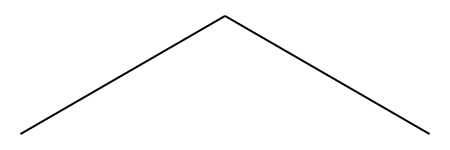

In [50]:
substructure_filter

In [61]:
matches = [k for k,v in smiles_and_rdkit_obj_dropNone.items() if v.HasSubstructMatch(substructure_filter)]

In [64]:
matches

[' ',
 '    [H][C@@](O)(CC1=CC=C(O)C=C1)C(O)=N[C@@]([H])(C(=O)N1[C@@]([H])(C[C@]2([H])CC[C@]([H])(C[C@]12[H])OS(O)(=O)=O)C(O)=NCCCCNC(N)=N)[C@]([H])(C)CC',
 ' Br[C@@H](CC1)[C@](CC[C@H]([C@@](CC[C@H](C(C)(C)OC2=O)Br)(C)O)Br)(C)[C@@](CC(C=C2C=C3)=C3O)([H])C1=C',
 ' C(C(C(=O)O)N)C(=O)O',
 ' C(C(C(=O)O)N)O',
 ' C/C(=C\\CCC(=C)C(CN=C(Cl)Cl)Cl)/CCC1C(O1)(C)C',
 ' C/C(C)=C\\C/C=C(C)/C1C(C(N([H])C1)C(O)=O)CC(O)=O',
 ' C12=C(NC(=O)N1)NC(=O)NC2=O',
 ' C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O',
 ' C1=CC(=CC=C1C2=CC(=O)C3=C(C(=C(C=C3O2)O)O)O)O',
 ' C1C(C(C(CC1(C(=O)O)O)OC(=O)C=CC2=CC(=C(C=C2)O)O)O)O',
 ' C1[C@@H]([C@H](OC2=CC(=CC(=C21)O)O)C3=CC(=C(C(=C3)O)O)O)O',
 ' C1[C@H](C([C@@H](CC1(C(=O)O)O)O)O)O',
 ' C=C([C@]1([H])OC(C)=O)[C@H](OC(C)=O)[C@@H](OC(C)=O)C(C(C)(C)/C=C/[C@@H](C)C([C@]2(OC(C)=O)[C@]1([H])[C@@H](OC(C)=O)[C@](C)(O)C2)=O)=O',
 ' CC(/C=C/C=C(C)C)C1CCC(CC1)(C)[N+]#[C-]',
 ' CC(=O)N(CCCCCNC(=O)CCC(=O)N(CCCCCNC(=O)CCC(=O)N(CCCCCN)O)O)O',
 ' CC(C(NC1=O)C(NC(C(OC(CCC(C)CC(C)CC(C)/C

In [73]:
input_library_smallest_new[input_library_smallest_new['Smiles'].isin(matches)]

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,create_time,task_id,user_id,InChIKey_smiles,InChIKey_inchi,Formula_smiles,Formula_inchi,url,annotation_history,rdkit_obj
index,,,,,,,,,,,,,,,,,,,,,
0,CCMSLIB00000001547,130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[289.286377,8068.000000],[295.545288,22507.00...",splash10-0w2a-0001282259-0001282259,mwang87,...,2019-10-30 21:18:25.0,aa87bf9cd0784df9956753f435c32434,NaN,IYDKWWDUBYWQGF-NNAZGLEUSA-N,NaN,C48H72N10O12,NaN,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': '3-Des-Microcystein_LR', 'I...",<rdkit.Chem.rdchem.Mol object at 0x000001CED17...
1,CCMSLIB00000001548,20111105_Anada_Ger_HoiamideB_MH940_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[278.049927,35793.000000],[278.957642,47593.0...",splash10-00dl-0000011189-0000011189,mwang87,...,2019-06-04 02:55:49.0,cd4ed49954b94767a54918c340d18fa1,NaN,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN-ZNCJFREWSA-N,C45H73N5O10S3,C45H73N5O10S3,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Hoiamide B', 'Ion_Source':...",<rdkit.Chem.rdchem.Mol object at 0x000001CED17...
3,CCMSLIB00000001550,20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[343.896484,142503.000000],[345.458496,67939....",splash10-0002-0000190000-0000190000,mwang87,...,2019-07-23 10:38:26.0,ca48cf7bc6644f5e89f98d62f114dfea,NaN,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO-RPCRKUJJSA-N,C36H20N2O4,C36H20N2O4,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Scytonemin', 'Ion_Source':...",<rdkit.Chem.rdchem.Mol object at 0x000001CED27...
5,CCMSLIB00000001552,20120412_PAVL_FT_Hectochlorin_MCl37H_667_qb.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[200.205383,7905.953125],[201.312088,2282.589...",splash10-0a4i-0000119000-0000119000,mwang87,...,2019-11-04 11:35:10.0,a3612cf24ba246e5979778166475dc98,NaN,USXIYWCPCGVOKF-LERJCCFDSA-N,NaN,C27H34Cl2N2O9S2,NaN,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Hectochlorin', 'Ion_Source...",<rdkit.Chem.rdchem.Mol object at 0x000001CED27...
6,CCMSLIB00000001553,20120412_PAVL_FT_Hectochlorin_MCl37Na_689_qb.1...,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,"[[264.268188,44.800793],[336.234344,9.785302],...",splash10-0udi-0000009000-0000009000,mwang87,...,2021-03-18 16:28:22.0,72b0d8d7347441ef8e38a600f2182767,NaN,USXIYWCPCGVOKF-NOENWEJRSA-N,USXIYWCPCGVOKF-NOENWEJRSA-N,C27H34Cl2N2O9S2,C27H34Cl2N2O9S2,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,"[{'Compound_Name': 'Hectochlorin', 'Ion_Source...",<rdkit.Chem.rdchem.Mol object at 0x000001CED27...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CCMSLIB00005884809,madeleine.mgf,f92bb49bd6e64337b6cc3a154bb87d6b,1656,2,GNPS-LIBRARY,1,"[[50.199501,113.709999],[50.244900,101.389999]...",null-null-null-null,mwang87,...,2021-03-18 10:55:10.0,f92bb49bd6e64337b6cc3a154bb87d6b,NaN,DHCLVCXQIBBOPH-UHFFFAOYSA-N,NaN,C3H9O6P,NaN,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'GLYCEROL 2-PHOSPHATE - 40....,<rdkit.Chem.rdchem.Mol object at 0x000001CED27...
9996,CCMSLIB00005884810,madeleine.mgf,f92bb49bd6e64337b6cc3a154bb87d6b,1657,2,GNPS-LIBRARY,1,"[[50.495899,108.809998],[51.147400,116.580002]...",null-null-null-null,mwang87,...,2021-03-18 10:55:10.0,f92bb49bd6e64337b6cc3a154bb87d6b,NaN,DHCLVCXQIBBOPH-UHFFFAOYSA-N,NaN,C3H9O6P,NaN,https://gnps.ucsd.edu/ProteoSAFe/gnpslibrarysp...,[{'Compound_Name': 'GLYCEROL 2-PHOSPHATE - 50....,<rdkit.Chem.rdchem.Mol object at 0x000001CED27...
9997,CCMSLIB00005884811,madeleine.mgf,f92bb49bd6e64337b6cc3a154bb87d6b,1658,2,GNPS-LIBRARY,1,"[[50.340401,101.239998],[50.510300,95.309998],...",null-null-null-null,mwang87,...,2021-03-18 10:55:10.0,f92bb49bd6e64337b6cc3a154bb87d6b,NaN,DHCLVCXQIBBOPH-UHFFFAOYSA-N,NaN,C3H9O6

In [48]:
for k,v in smiles_and_rdkit_obj.items():
    print(v)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
